In [5]:
import jax
import jax.numpy as jnp
import numpy as np
import optax

from jaxkan.models.KAN import KAN

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [6]:
from Utils import *

class Config:
    N_INPUT = 2
    X_MIN = 0
    X_MAX = 1
    T_MAX = 1
    
    N_SPLINES_INIT = 3

    BS = 64
    BS_BC = 128
    EPOCHS = 10000
    
r = KeyHandler(0)

In [7]:
layer_dims = [Config.N_INPUT, 6, 6, 1]
model = KAN(layer_dims=layer_dims, k=Config.N_SPLINES_INIT, add_bias=True)

collocs = jax.random.normal(r.key(), (Config.BS, Config.N_INPUT))
variables = model.init(r.key(), collocs)

In [8]:
# only sample boundary once
BC1_colloc = jnp.array(sobol_sample(np.array([0,0]), np.array([1,0]), Config.BS_BC) )
BC1_data = jnp.sin(np.pi*BC1_colloc[:,0]).reshape(-1,1)

BC2_colloc = jnp.array(sobol_sample(np.array([0,0]), np.array([0,1]), Config.BS_BC))
BC2_data = jnp.zeros(BC2_colloc.shape[0]).reshape(-1,1)

BC3_colloc = jnp.array(sobol_sample(np.array([1,0]), np.array([1,1]), Config.BS_BC))
BC3_data = jnp.zeros(BC3_colloc.shape[0]).reshape(-1,1)

bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
bc_data = [BC1_data, BC2_data, BC3_data]

In [9]:
def get_pde_loss(model):
    @jax.jit
    def pde_loss_fn(params, collocs, state):
        def u(vec_x):
            y, spl_reg = model.apply(variables, vec_x)
            return y
        variables = {'params' : params, 'state' : state}

        u_xx = gradf(u, 0, 2)(collocs)
        u_t = gradf(u, 1, 1)(collocs)
        
        D = 1
        pde_residual = u_t - D*u_xx
        
        return pde_residual

    return pde_loss_fn

def get_pde_loss_2(model):
    @jax.jit
    def pde_loss_fn(params, collocs, state):
        def u(vec_x):
            y, spl_reg = model.apply(variables, vec_x)
            return y
        variables = {'params' : params, 'state' : state}

        u_xx = gradf(u, 0, 2)(collocs)
        u_t = gradf(u, 1, 1)(collocs)
        
        f = (jnp.pi**2 - 1)*jnp.exp(-collocs[:, 1])*jnp.sin(jnp.pi*collocs[:, 0])
        f = f.reshape(-1,1)
        
        D = 1
        pde_residual = u_t - D*u_xx - f
        
        return pde_residual

    return pde_loss_fn

def get_vanilla_loss(model, pde_loss_fn):
    @jax.jit
    def vanilla_loss(params, collocs, bc_collocs, bc_data, state):
        def u(vec_x):
            y, spl_reg = model.apply(variables, vec_x)
            return y
        variables = {'params' : params, 'state' : state}
        
        pde_residual = pde_loss_fn(params, collocs, state)
        
        bc_loss = 0
        for (bc_x, bc_y) in zip(bc_collocs, bc_data):
            bc_loss += jnp.mean((u(bc_x) - bc_y)**2)
        
        loss = jnp.mean(pde_residual**2) + bc_loss/3
        return loss

    return vanilla_loss
    


colloc_x = jax.random.uniform(r.key(), (Config.BS,), minval=Config.X_MIN, maxval=Config.X_MAX)
colloc_t= jax.random.uniform(r.key(), (Config.BS,), minval=0, maxval=Config.T_MAX)
collocs = jnp.stack((colloc_x, colloc_t), axis=-1)

params, state = variables["params"], variables["state"]

pde_loss = get_pde_loss_2(model)
loss = get_vanilla_loss(model, pde_loss)(params, collocs, bc_collocs, bc_data, state)
loss

Array(20.53449, dtype=float32)

In [10]:
def get_train_step(model, optimizer, loss_fn):
    @jax.jit
    def train_step(params, collocs, bc_collocs, bc_data, opt_state, state):
        grad_fn = jax.value_and_grad(loss_fn)
        loss, grads = grad_fn(params, collocs, bc_collocs, bc_data, state)

        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return params, loss, opt_state
    
    return train_step

schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-3,  # Initial learning rate
    decay_steps=Config.EPOCHS,  # Total number of decay steps
    alpha=0.1          # Final learning rate multiplier (alpha * initial value)
)
optimizer = optax.adam(learning_rate=schedule_fn)
# optimizer = optax.sgd(learning_rate=1e-4)
opt_state = optimizer.init(variables['params'])

pde_loss = get_pde_loss_2(model)
loss_fn = get_vanilla_loss(model, pde_loss)
train_step = get_train_step(model, optimizer, loss_fn)

In [7]:
%%time
# grid_extensions = {1000:5, 2000:10} # epochs to extend grid and n_spline
grid_extensions = {}

losses = []
for i in (pbar:= tqdm(range(Config.EPOCHS))):
    collocs = jnp.array(sobol_sample(np.array([Config.X_MIN,0]), np.array([Config.X_MAX,Config.T_MAX]), Config.BS))
    
    params, state = variables["params"], variables["state"]
    params, loss, opt_state = train_step(params, collocs, bc_collocs, bc_data, opt_state, state)
    # update params
    variables = {'params': params, 'state': state}
    
    pbar.set_description(f"Loss {loss: .4f}")
    losses.append(loss)
    
    if i in grid_extensions:
        # update grid to use 2 more splines in each grid
        n_splines = grid_extensions[i]
        
        updated_variables = model.apply(variables, collocs, n_splines, method=model.update_grids)
        variables = updated_variables.copy()
        # reset opt state, dirty solution
        opt_state = optimizer.init(variables['params'])

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 2min 29s, sys: 19 s, total: 2min 48s
Wall time: 2min 31s


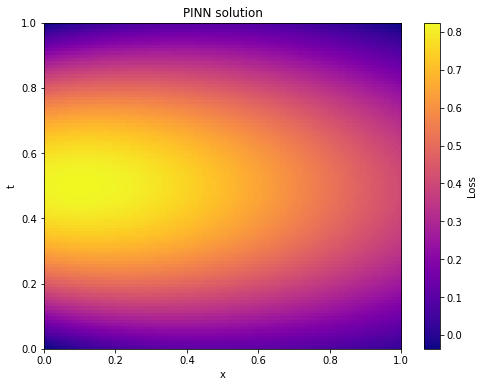

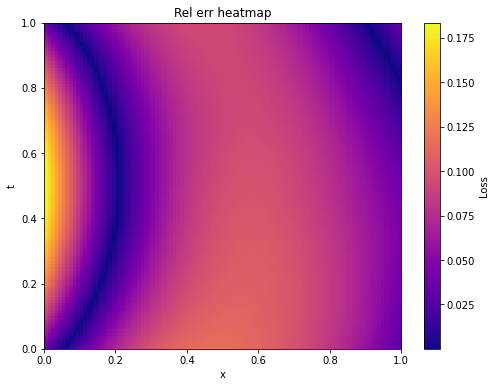

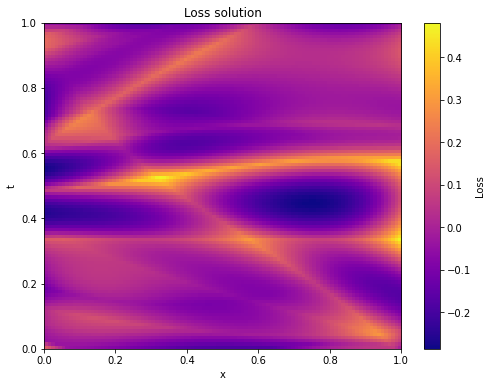

L2 error 0.1674


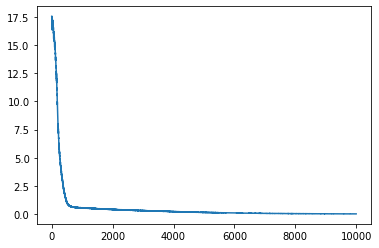

In [8]:
def plot_heatmap(arr, title):
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(arr, extent=(0, Config.T_MAX, Config.X_MIN, Config.X_MAX), origin="lower", aspect="auto", cmap="plasma")
    plt.colorbar(label="Loss")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.title(title)
    plt.show()

params, state = variables["params"], variables["state"]
def u(vec_x):
    y, spl_reg = model.apply(variables, vec_x)
    return y

def exact_u(vec_x):
    y = jnp.sin(jnp.pi*vec_x[:, 0])*jnp.exp(-jnp.pi**2 * vec_x[:, 1])
    return y

def exact_u_2(vec_x):
    y = jnp.sin(jnp.pi*vec_x[:, 0])*jnp.exp(-vec_x[:, 1])
    return y

def l2_error(results, true):
    err = jnp.sum((results - true)**2) / jnp.sum(true**2)
    err = jnp.sqrt(err)
    return err

N = 100 # NxN grid
x_grid = jnp.linspace(Config.X_MIN, Config.X_MAX, N)
t_grid = jnp.linspace(0, Config.T_MAX, N)

# Create a meshgrid of x and t values
x_mesh, t_mesh = jnp.meshgrid(x_grid, t_grid, indexing="ij")
x_flat = x_mesh.flatten()
t_flat = t_mesh.flatten()
collocs = jnp.stack((x_flat, t_flat), axis=-1)

results = u(collocs).reshape(N, N)
loss = pde_loss(params, collocs, state).reshape(N, N)
exact = exact_u_2(collocs).reshape(N,N)

plot_heatmap(results,"PINN solution")
plot_heatmap(jnp.abs(results - exact),"Rel err heatmap")
plot_heatmap(loss,"Loss solution")

l2_err = l2_error(results, exact)

print(f"L2 error {l2_err:.4f}")
plt.plot(losses)

# Helmholtz

In [16]:
from Utils import *

class Config:
    N_INPUT = 2
    X_MIN = -1
    X_MAX = 1
    
    Y_MIN = -1
    Y_MAX = 1

    BS = 128
    BS_BC = 256
    EPOCHS = 10000
    
    N_SPLINES_INIT = 3
    layer_dims = [N_INPUT, 6, 6, 1]
    
r = KeyHandler(0)

In [17]:
def get_pde_Helmholtz(model):
    @jax.jit
    def pde_loss_fn(params, collocs, state):
        def u(vec_x):
            y, spl_reg = model.apply(variables, vec_x)
            return y
        variables = {'params' : params, 'state' : state}
        
        y = u(collocs)
        u_xx = gradf(u, 0, 2)(collocs)
        u_yy = gradf(u, 1, 2)(collocs)
        
        f = (1-17*jnp.pi**2)*jnp.sin(jnp.pi*collocs[:, 0])*jnp.sin(4*jnp.pi*collocs[:, 1])
        f = f.reshape(-1,1)
        
        D = 1
        pde_residual = u_xx + u_yy + y - f
        
        return pde_residual

    return pde_loss_fn

def get_vanilla_loss(model, pde_loss_fn):
    @jax.jit
    def vanilla_loss(params, collocs, bc_collocs, bc_data, state):
        def u(vec_x):
            y, spl_reg = model.apply(variables, vec_x)
            return y
        variables = {'params' : params, 'state' : state}
        
        pde_residual = pde_loss_fn(params, collocs, state)
        
        bc_loss = 0
        for (bc_x, bc_y) in zip(bc_collocs, bc_data):
            bc_loss += jnp.mean((u(bc_x) - bc_y)**2)
        
        loss = jnp.mean(pde_residual**2) + 5*bc_loss
        return loss

    return vanilla_loss

#init model
model = KAN(layer_dims=Config.layer_dims, k=Config.N_SPLINES_INIT, add_bias=True)
collocs = jnp.ones((Config.BS, Config.N_INPUT))
variables = model.init(r.key(), collocs)

schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-2,  # Initial learning rate
    decay_steps=Config.EPOCHS,  # Total number of decay steps
    alpha=0.1          # Final learning rate multiplier (alpha * initial value)
)
optimizer = optax.adam(learning_rate=schedule_fn)
opt_state = optimizer.init(variables['params'])

pde_loss = get_pde_Helmholtz(model)
loss_fn = get_vanilla_loss(model, pde_loss)
train_step = get_train_step(model, optimizer, loss_fn)

In [18]:
# only sample boundary once
BC1_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([-1,1]), Config.BS_BC))
BC1_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

BC2_colloc = jnp.array(sobol_sample(np.array([1,-1]), np.array([1,-1]), Config.BS_BC))
BC2_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

BC3_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([1,-1]), Config.BS_BC))
BC3_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

BC4_colloc = jnp.array(sobol_sample(np.array([-1,1]), np.array([1,1]), Config.BS_BC))
BC4_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc, BC4_colloc]
bc_data = [BC1_data, BC2_data, BC3_data, BC4_data]

In [19]:
%%time
grid_extensions = {}

losses = []
for i in (pbar:= tqdm(range(Config.EPOCHS))):
    collocs = jnp.array(sobol_sample(np.array([Config.X_MIN,Config.Y_MIN]), 
                                     np.array([Config.X_MAX,Config.Y_MAX]), Config.BS))
    
    params, state = variables["params"], variables["state"]
    params, loss, opt_state = train_step(params, collocs, bc_collocs, bc_data, opt_state, state)
    # update params
    variables = {'params': params, 'state': state}
    
    pbar.set_description(f"Loss {loss: .4f}")
    losses.append(loss)
    
    if i in grid_extensions:
        # update grid to use 2 more splines in each grid
        n_splines = grid_extensions[i]
        
        updated_variables = model.apply(variables, collocs, n_splines, method=model.update_grids)
        variables = updated_variables.copy()
        # reset opt state, dirty solution
        opt_state = optimizer.init(variables['params'])

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 6min 16s, sys: 39.1 s, total: 6min 56s
Wall time: 6min 21s


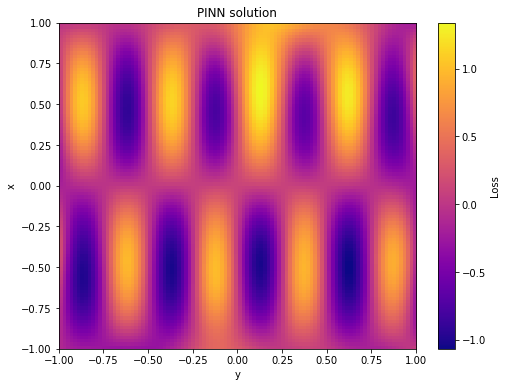

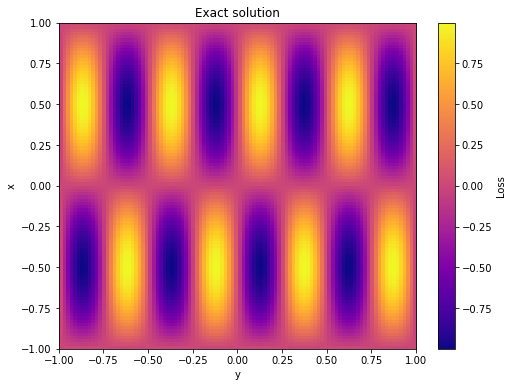

In [20]:
def plot_heatmap(arr, title):
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(arr, extent=(Config.X_MIN, Config.X_MAX, 
                            Config.Y_MIN, Config.Y_MAX), origin="lower", aspect="auto", cmap="plasma")
    plt.colorbar(label="Loss")
    plt.xlabel("y")
    plt.ylabel("x")
    plt.title(title)
    plt.show()

params, state = variables["params"], variables["state"]
def u(vec_x):
    y, spl_reg = model.apply(variables, vec_x)
    return y

def exact_u(vec_x):
    y = jnp.sin(jnp.pi*vec_x[:, 0])*jnp.sin(4*jnp.pi*vec_x[:, 1])
    return y

def l2_error(results, true):
    err = jnp.sum((results - true)**2) / jnp.sum(true**2)
    err = jnp.sqrt(err)
    return err

N = 100 # NxN grid
x_grid = jnp.linspace(Config.X_MIN, Config.X_MAX, N)
y_grid = jnp.linspace(Config.Y_MIN, Config.Y_MAX, N)

# Create a meshgrid of x and t values
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing="ij")
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
collocs = jnp.stack((x_flat, y_flat), axis=-1)

results = u(collocs).reshape(N, N)
loss = pde_loss(params, collocs, state).reshape(N, N)
exact = exact_u(collocs).reshape(N,N)

plot_heatmap(results,"PINN solution")
plot_heatmap(exact,"Exact solution")

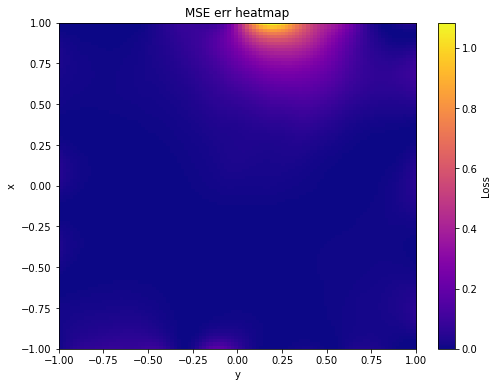

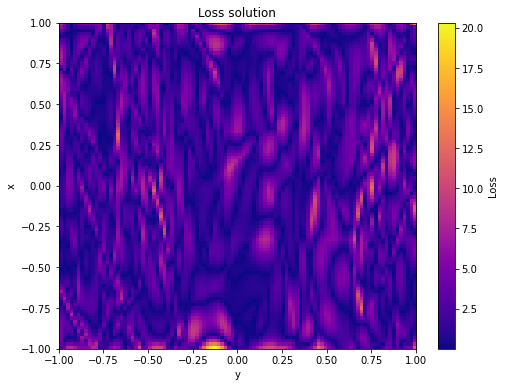

L2 error 40.8490%


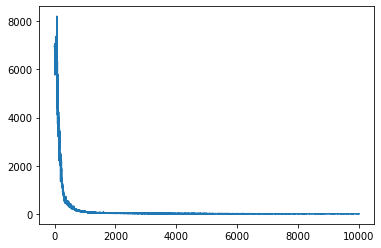

In [26]:
plot_heatmap(jnp.abs(results - exact)**2,"MSE err heatmap")
plot_heatmap(jnp.abs(loss),"Loss solution")

l2_err = l2_error(results, exact)
print(f"L2 error {l2_err*100:.4f}%")
plt.plot(losses)

In [35]:
std = 5
B = jax.random.normal(r.key(), (64//2,2)) * std

x = collocs[0, :]
x = jnp.matmul(B, x)
x = jnp.concatenate([jnp.cos(collocs), jnp.sin(x)])

TypeError: Cannot concatenate arrays with different numbers of dimensions: got (10000, 2), (32,).